# Exploration of baby data with finetuned catboost

### Copied fold evaluation by paddykb, see his notebook at:https://www.kaggle.com/code/paddykb/lgbm-mapie-birth-weight-oh-my

Update: Fixed outlier function and categorial variables

In [1]:
!pip install mapie

  Obtaining dependency information for mapie from https://files.pythonhosted.org/packages/a3/78/65821c38efac951d312eab082785cb99be418a77a1bb81f9097465a363d3/MAPIE-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 3.0 MB/s eta 0:00:00


In [2]:
# load packages
import sys
sys.path.append('/kaggle/input/winkler-interval-score-metric/')
import MWIS_metric
import shap
from mapie.quantile_regression import MapieQuantileRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import optuna
from optuna.samplers import TPESampler
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from mapie.regression import MapieRegressor

import os
import warnings
warnings.filterwarnings('ignore')
# suppress tf informational and warning messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


In [3]:
# load data
train = pd.read_csv('/kaggle/input/prediction-interval-competition-i-birth-weight/train.csv')
test = pd.read_csv('/kaggle/input/prediction-interval-competition-i-birth-weight/test.csv')
train.head(3)

,id,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DMAR,DOB_MM,DOB_TT,DOB_WK,...,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESAR,RF_CESARN,SEX,WTGAIN,DBWT
0,0,1,1,18.5,0,12,,10,1434,5,...,0,0,108,1,1,N,0,F,24,2800
1,1,1,1,18.3,2,4,1,12,2156,6,...,2,1,100,1,1,N,0,M,18,1900
2,2,1,1,27.3,0,3,2,12,1241,2,...,2,2,135,4,1,Y,2,F,27,2960


In [4]:
# color the cells based on their value
def color_negative_red(val):
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

# describe the data set
train.drop(columns='id').describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
ATTEND,108082.000000,1.330046,0.765864,1.000000,1.000000,1.000000,1.000000,9.000000
BFACIL,108082.000000,1.033891,0.310660,1.000000,1.000000,1.000000,1.000000,9.000000
BMI,108082.000000,28.848412,12.731588,13.200000,22.300000,25.800000,31.200000,99.900000
CIG_0,108082.000000,1.557336,8.217045,0.000000,0.000000,0.000000,0.000000,99.000000
DLMP_MM,108082.000000,10.949048,19.837302,1.000000,4.000000,7.000000,10.000000,99.000000
DOB_MM,108082.000000,6.570835,3.421184,1.000000,4.000000,7.000000,10.000000,12.000000
DOB_TT,108082.000000,1233.242085,632.722133,0.000000,801.000000,1238.000000,1735.000000,9999.000000
DOB_WK,108082.000000,4.055162,1.855129,1.000000,2.000000,4.000000,6.000000,7.000000
FAGECOMB,108082.000000,39.630447,22.471849,14.000000,28.000000,33.000000,38.000000,99.000000
FEDUC,108082.000000,4.903842,2.303684,1.000000,3.000000,4.000000,6.000000,9.000000


In [5]:
# color the cells based on their value
def color_negative_red(val):
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

# describe the data set
test.drop(columns='id').describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
ATTEND,5689.000000,1.316576,0.756227,1.000000,1.000000,1.000000,1.000000,9.000000
BFACIL,5689.000000,1.032870,0.294957,1.000000,1.000000,1.000000,1.000000,7.000000
BMI,5689.000000,28.753436,12.308691,13.900000,22.300000,25.800000,31.300000,99.900000
CIG_0,5689.000000,1.691510,9.182817,0.000000,0.000000,0.000000,0.000000,99.000000
DLMP_MM,5689.000000,11.009492,20.002485,1.000000,4.000000,7.000000,10.000000,99.000000
DOB_MM,5689.000000,6.530322,3.442337,1.000000,4.000000,7.000000,10.000000,12.000000
DOB_TT,5689.000000,1232.954825,638.686470,0.000000,800.000000,1244.000000,1728.000000,9999.000000
DOB_WK,5689.000000,4.041132,1.841389,1.000000,3.000000,4.000000,6.000000,7.000000
FAGECOMB,5689.000000,39.593602,22.324832,15.000000,28.000000,33.000000,38.000000,99.000000
FEDUC,5689.000000,4.930568,2.293802,1.000000,3.000000,4.000000,6.000000,9.000000


In [6]:
# get frequency and cardinality of features
cats=train.columns

def analyse_cats(df, cat_cols):
    d = pd.DataFrame()
    cl = [];u = [];s =[]; nans =[]
    for c in cat_cols:
        #print("column:" , c ,"--Uniques:" , train[c].unique(), "--Cardinality:", train[c].unique().size)
        cl.append(c); u.append(df[c].unique());s.append(df[c].unique().size);nans.append(df[c].isnull().sum())
        
    d['"feat"'] = cl;d["uniques"] = u; d["cardinality"] = s; d["nans"] = nans
    return d

plt.style.use('fivethirtyeight')
catanadf = analyse_cats(train, cats)
catanadf

,"""feat""",uniques,cardinality,nans
0,id,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",108082,0
1,ATTEND,"[1, 2, 3, 4, 5, 9]",6,0
2,BFACIL,"[1, 7, 3, 2, 5, 4, 6, 9]",8,0
3,BMI,"[18.5, 18.3, 27.3, 24.0, 23.6, 99.9, 29.8, 25....",498,0
4,CIG_0,"[0, 2, 8, 20, 10, 12, 5, 40, 13, 6, 99, 3, 4, ...",40,0
5,DLMP_MM,"[12, 4, 3, 7, 6, 99, 8, 9, 10, 5, 1, 11, 2]",13,0
6,DMAR,"[ , 1, 2]",3,0
7,DOB_MM,"[10, 12, 4, 3, 9, 7, 6, 5, 2, 8, 11, 1]",12,0
8,DOB_TT,"[1434, 2156, 1241, 1649, 752, 2050, 1358, 2059...",1441,0
9,DOB_WK,"[5, 6, 2, 7, 3, 4, 1]",7,0


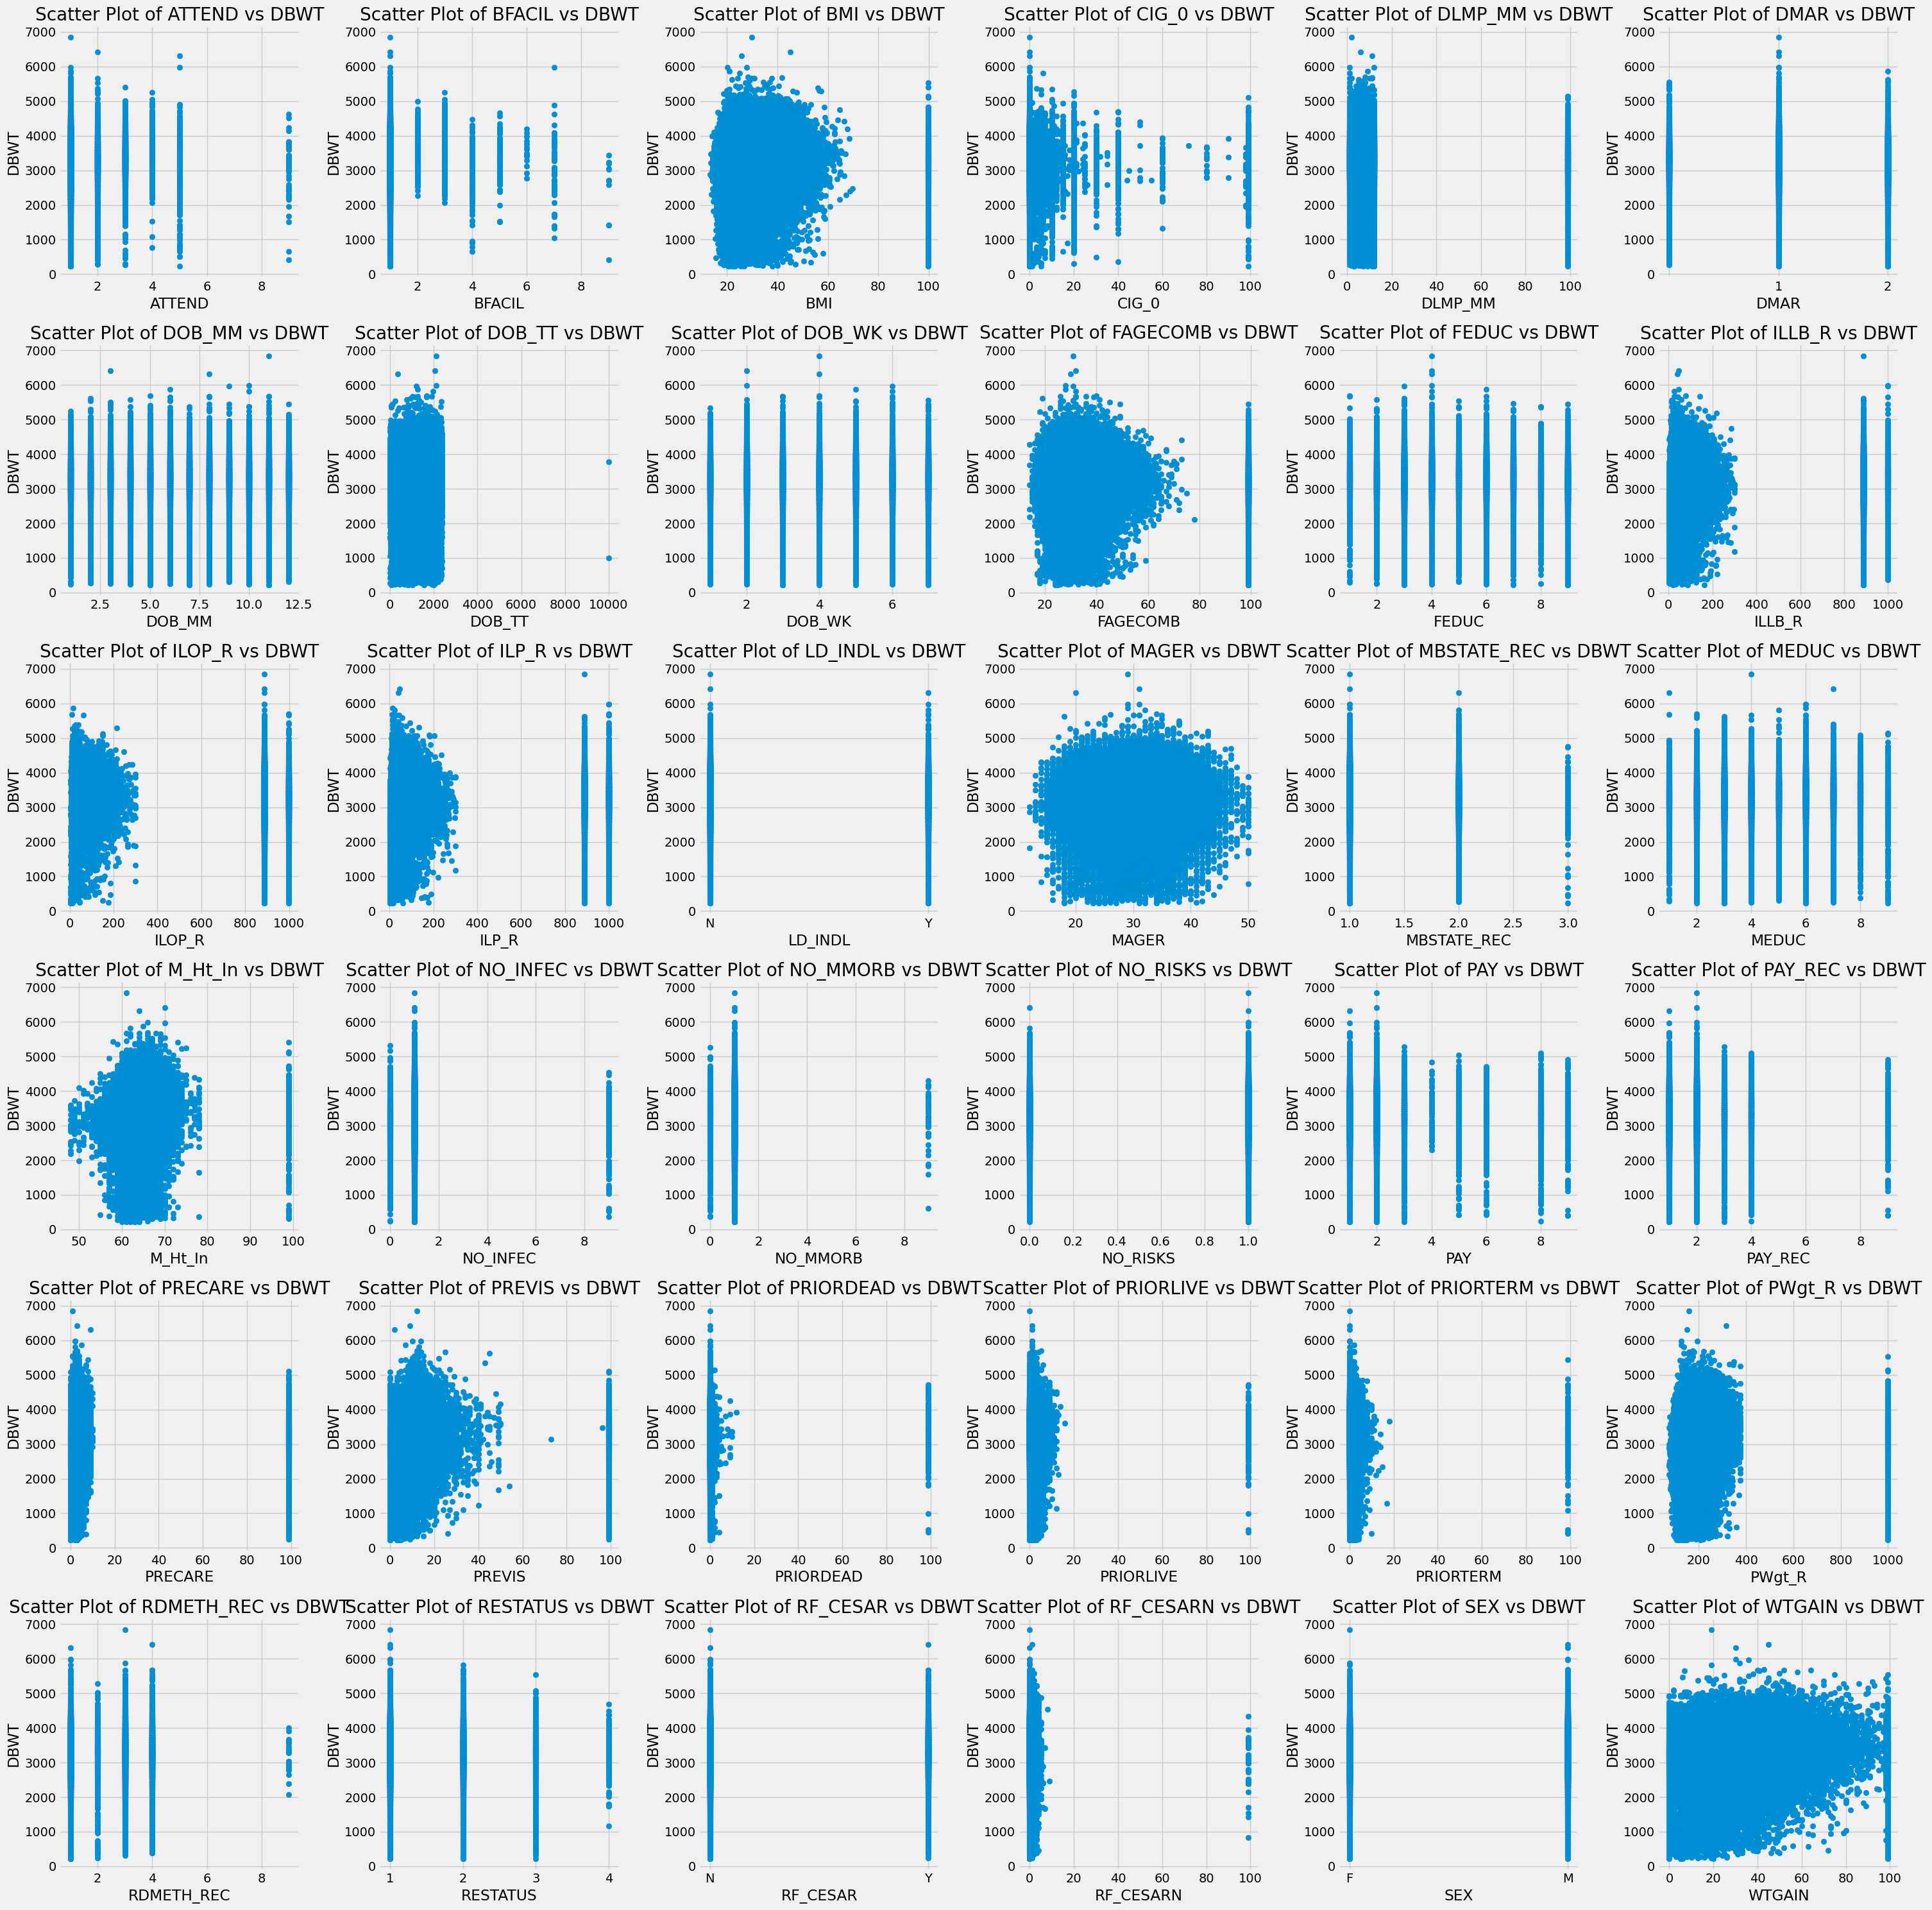

In [7]:
import math
# Identify columns to plot (all except the first and last)
columns_to_plot = train.columns[1:-1]

# Number of plots
n_plots = len(columns_to_plot)
# Determine grid dimensions
n_cols = int(math.ceil(math.sqrt(n_plots)))
n_rows = int(math.ceil(n_plots / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Target column is the last column
target_col = train.columns[-1]

# Iterate over each column and create a scatter plot
for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    ax.scatter(train[col],train[target_col])
    ax.set_xlabel(col)
    ax.set_ylabel(target_col)
    ax.set_title(f'Scatter Plot of {col} vs {target_col}')

# Hide any unused subplots
for i in range(n_plots, len(axes)):
    axes[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

## Outliers

We can observe some outliers, which make no sense as women that are 99 inches tall do not exists, aswell as other measurements.
We should handle those outliers in both sets as NULL values.

Furthremore as seen from the scatterplots a lot of the variables are clearly not numeric and hav eto be transformed to cat variables

In [8]:
TARGET_NAME = 'DBWT'
# load data
train = pd.read_csv('/kaggle/input/prediction-interval-competition-i-birth-weight/train.csv')
test = pd.read_csv('/kaggle/input/prediction-interval-competition-i-birth-weight/test.csv')
train.head(3)
## convert outliers to null value in both train and test
def fix_outliers(df):
    # calculaute approximate term of pregnancy
    # encode unknown as 0:
    df['pregnancy_length'] = np.where(df['DLMP_MM'] != 99, df['DOB_MM'] - df['DLMP_MM'], np.nan)
    df['pregnancy_length'] = np.where(df['pregnancy_length'] < 0, df['pregnancy_length'] + 12, df['pregnancy_length'])
    condition =[df['pregnancy_length'].eq(9),
                df['pregnancy_length'].eq(8),
                df['pregnancy_length'].eq(10),
                df['pregnancy_length'].eq(0),
                df['pregnancy_length'].lt(7)]
                
    choices = [
              '9',
              '8',
               '10',
            'unknown',
               'Early']
    df['pregnancy_length_cat'] = np.select(condition,choices, 'Late')
    df['pregnancy_length_cat'] = df['pregnancy_length_cat'].astype(object)
    df=df.drop(columns='pregnancy_length')
    
    df['M_Ht_In'] = np.where(df['M_Ht_In'] != 99,df['M_Ht_In'], np.nan)
    df['BMI'] = np.where(df['M_Ht_In'] != 99.9,df['M_Ht_In'], np.nan)
    df['CIG_0'] = np.where(df['CIG_0'] != 99,df['CIG_0'], np.nan)
    df['FAGECOMB'] = np.where(df['FAGECOMB'] != 99,df['FAGECOMB'], np.nan)
    df['PRECARE'] = np.where(df['PRECARE'] != 99,df['PRECARE'], np.nan)
    df['PREVIS'] = np.where(df['PREVIS'] != 99,df['PREVIS'], np.nan)
    df['PRIORDEAD'] = np.where(df['PRIORDEAD'] != 99,df['PRIORDEAD'], np.nan)
    df['PRIORLIVE'] = np.where(df['PRIORLIVE'] != 99,df['PRIORLIVE'], np.nan)
    df['PRIORTERM'] = np.where(df['PRIORTERM'] != 99,df['PRIORTERM'], np.nan)
    df['PWgt_R'] = np.where(df['PWgt_R'] != 999,df['PWgt_R'], np.nan)
    df['RF_CESARN'] = np.where(df['RF_CESARN'] != 99,df['RF_CESARN'], np.nan)
    df['WTGAIN'] = np.where((df['WTGAIN'] == 99)|(df['WTGAIN'] == 0), np.nan,df['WTGAIN'])
    df['ATTEND'] = np.where(df['ATTEND'] != 9,df['ATTEND'], np.nan)
    
    ### a lot of varibales can be seen as categorical therefore I transform them, comment if you see a better relationship for them
    # place of birth is categorical
    replacement_dict = {1: 'class 1', 2: 'class 2', 3: 'class 3', 4: 'class 4', 
                        5: 'class 5', 6: 'class 6', 7: 'class 7', 8: 'class 8', 9: 'unknown'}
    df['BFACIL'] = df['BFACIL'].map(replacement_dict)
    df['BFACIL'] = df['BFACIL'].astype(object)
    
    # Status of marriages is either none or not
    df['DMAR'] = np.where(df['DMAR'] ==' ','unknown',np.where(df['DMAR']=='1','no','yes'))
    df['DMAR'] = df['DMAR'].astype(object)
    
    # month of birth and last menses are categorical aswell, we could built pregnancy length but the tree should see the interaction aswell
    replacement_dict = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 
                        5: 'May', 6: 'June', 7: 'July',8:'August',9:'September',10:'Oktober',11:'November',12:'December'}
    df['DOB_MM'] = df['DOB_MM'].map(replacement_dict)
    df['DOB_MM'] = df['DOB_MM'].astype(object)
    
    replacement_dict = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 
                        5: 'May', 6: 'June', 7: 'July',8:'August',9:'September',10:'Oktober',11:'November',12:'December',99:'unknown'}

    df['DLMP_MM'] = df['DLMP_MM'].map(replacement_dict)
    df['DLMP_MM'] = df['DLMP_MM'].astype(object)
    
    # also week of birth is categorical 
    replacement_dict = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 
                        5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
    df['DOB_WK'] = df['DOB_WK'].map(replacement_dict)
    df['DOB_WK'] = df['DOB_WK'].astype(object)
    
    # Status of infection
    df['NO_INFEC'] = np.where(df['NO_INFEC'] == 9,'unknown',np.where(df['NO_INFEC']==1,'yes','no'))
    df['NO_INFEC'] = df['NO_INFEC'].astype(object)
    
    # nativity of mother
    df['MBSTATE_REC'] = np.where(df['MBSTATE_REC'] == 9,'unknown',np.where(df['MBSTATE_REC']==1,'yes','no'))
    df['MBSTATE_REC'] = df['MBSTATE_REC'].astype(object)
    
    # education of fathers and mothers

    replacement_dict = {1: 'class 1', 2: 'class 2', 3: 'class 3', 4: 'class 4', 
                        5: 'class 5', 6: 'class 6', 7: 'class 7', 8: 'class 8', 9: 'unknown'}
    df['FEDUC'] = df['FEDUC'].map(replacement_dict)
    df['FEDUC'] = df['FEDUC'].astype(object)
    df['MEDUC'] = df['MEDUC'].map(replacement_dict)
    df['MEDUC'] = df['MEDUC'].astype(object)
    
    # lindl is cat
    df['LD_INDL'] = df['LD_INDL'].astype(object)
    
    # NO_MMORB as well 
    df['NO_MMORB'] = np.where(df['NO_MMORB'] == 9,'unknown',np.where(df['NO_MMORB']==1,'yes','no'))
    df['NO_MMORB'] = df['NO_MMORB'].astype(object)
    
    # NO_Risks as well 
    df['NO_RISKS'] = np.where(df['NO_RISKS'] == 1,'yes','no')
    df['NO_RISKS'] = df['NO_RISKS'].astype(object)
    
    #  Pay has many classes
    replacement_dict = {1: 'class 1', 2: 'class 2', 3: 'class 3', 4: 'class 4', 
                        5: 'class 5', 6: 'class 6', 7: 'class 7', 8: 'class 8', 9: 'unknown'}
    df['PAY'] = df['PAY'].map(replacement_dict)
    df['PAY'] = df['PAY'].astype(object)
    
    #  PAY_Rec also
    replacement_dict = {1: 'class 1', 2: 'class 2', 3: 'class 3', 4: 'class 4', 
                        5: 'class 5', 6: 'class 6', 7: 'class 7', 8: 'class 8', 9: 'unknown'}
    df['PAY_REC'] = df['PAY_REC'].map(replacement_dict)
    df['PAY_REC'] = df['PAY_REC'].astype(object)
    
    #  RDMETH_REC also
    replacement_dict = {1: 'class 1', 2: 'class 2', 3: 'class 3', 4: 'class 4', 
                        5: 'class 5', 6: 'class 6', 7: 'class 7', 8: 'class 8', 9: 'unknown'}
    df['RDMETH_REC'] = df['RDMETH_REC'].map(replacement_dict)
    df['RDMETH_REC'] = df['RDMETH_REC'].astype(object)
    
    df['SEX'] = df['SEX'].astype(object)
    # ilop_r et
    df['ILLB_R'] = np.where(df['ILLB_R'] == 999,np.nan,np.where(df['ILLB_R'] == 888,np.nan,df['ILLB_R']))
    df['ILOP_R'] = np.where(df['ILOP_R'] == 999,np.nan,np.where(df['ILOP_R'] == 888,np.nan,df['ILOP_R']))
    df['ILP_R'] = np.where(df['ILP_R'] == 999,np.nan,np.where(df['ILP_R'] == 888,np.nan,df['ILP_R']))

    return df

train = fix_outliers(train)
test = fix_outliers(test)

# After we have the pregnancy length we can bin the time to a more readable format of 24 hours

In [9]:
def bin_to_hour(time):
    if pd.isna(time) or time==9999:
        return np.nan # Return NaN if the value is NaN
    else:
        hours = int(time // 100)
        return hours

train['DOB_TT_normalized'] = train['DOB_TT'].apply(bin_to_hour)
train=train.drop(columns='DOB_TT')

test['DOB_TT_normalized'] = test['DOB_TT'].apply(bin_to_hour)
test=test.drop(columns='DOB_TT')

# Motivation for engineering ILLB_R,ILOP_R,ILP_R

* All three variables are highly correlated if you remove their nans, especially ILLB_R with ILP_R 
* Therefore it makes sense to keep only tow and bin them, because if there is no record then no previous birth or term was recorded. 

In [10]:
# define functions
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

missing_values_table(train)

Your selected dataframe has 39 columns.
There are 17 columns that have missing values.


,Missing Values,% of Total Values
ILOP_R,89196,82.5
ILP_R,46114,42.7
ILLB_R,44262,41.0
FAGECOMB,12573,11.6
WTGAIN,6311,5.8
PREVIS,2745,2.5
PRECARE,2668,2.5
PWgt_R,2187,2.0
M_Ht_In,548,0.5
BMI,548,0.5


<Axes: >

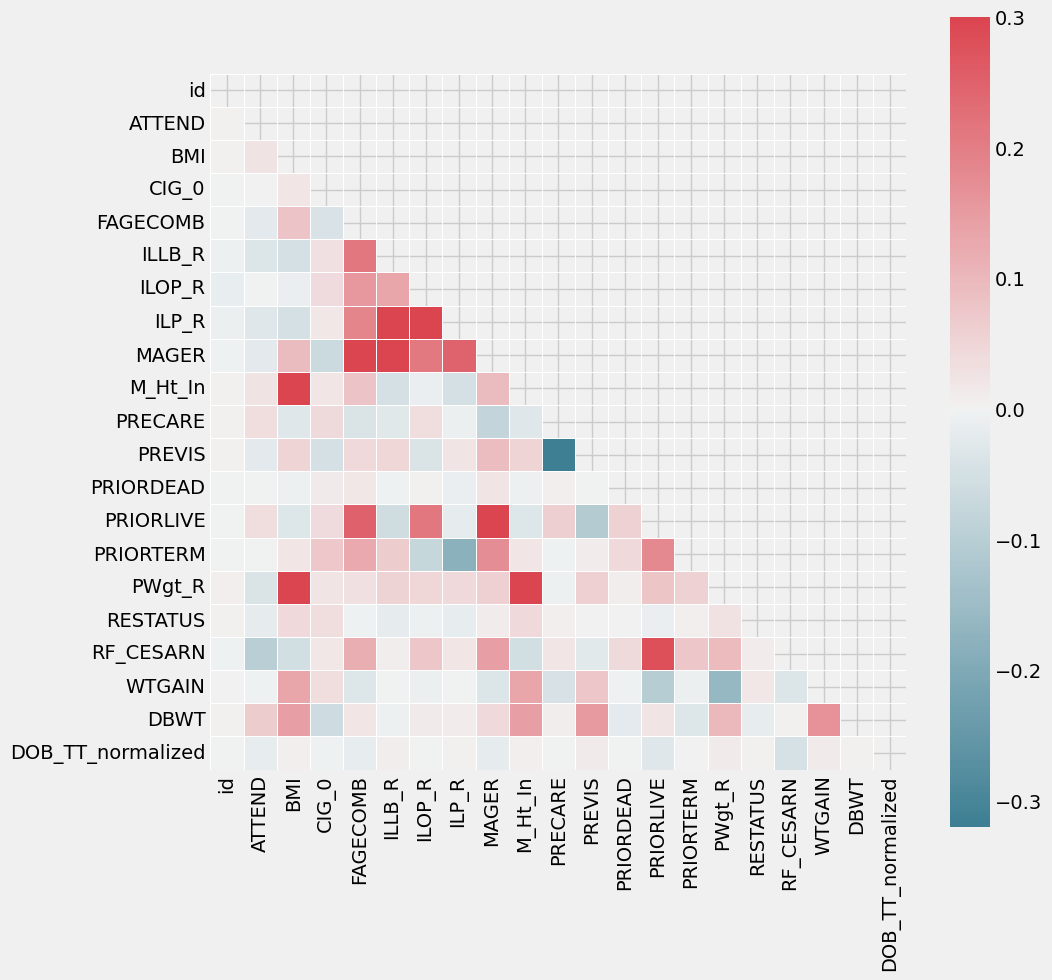

In [11]:
# create the heatmap dataset
df2=train.select_dtypes(exclude='object')

# Compute the correlation matrix
corr = df2.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool_))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=False, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

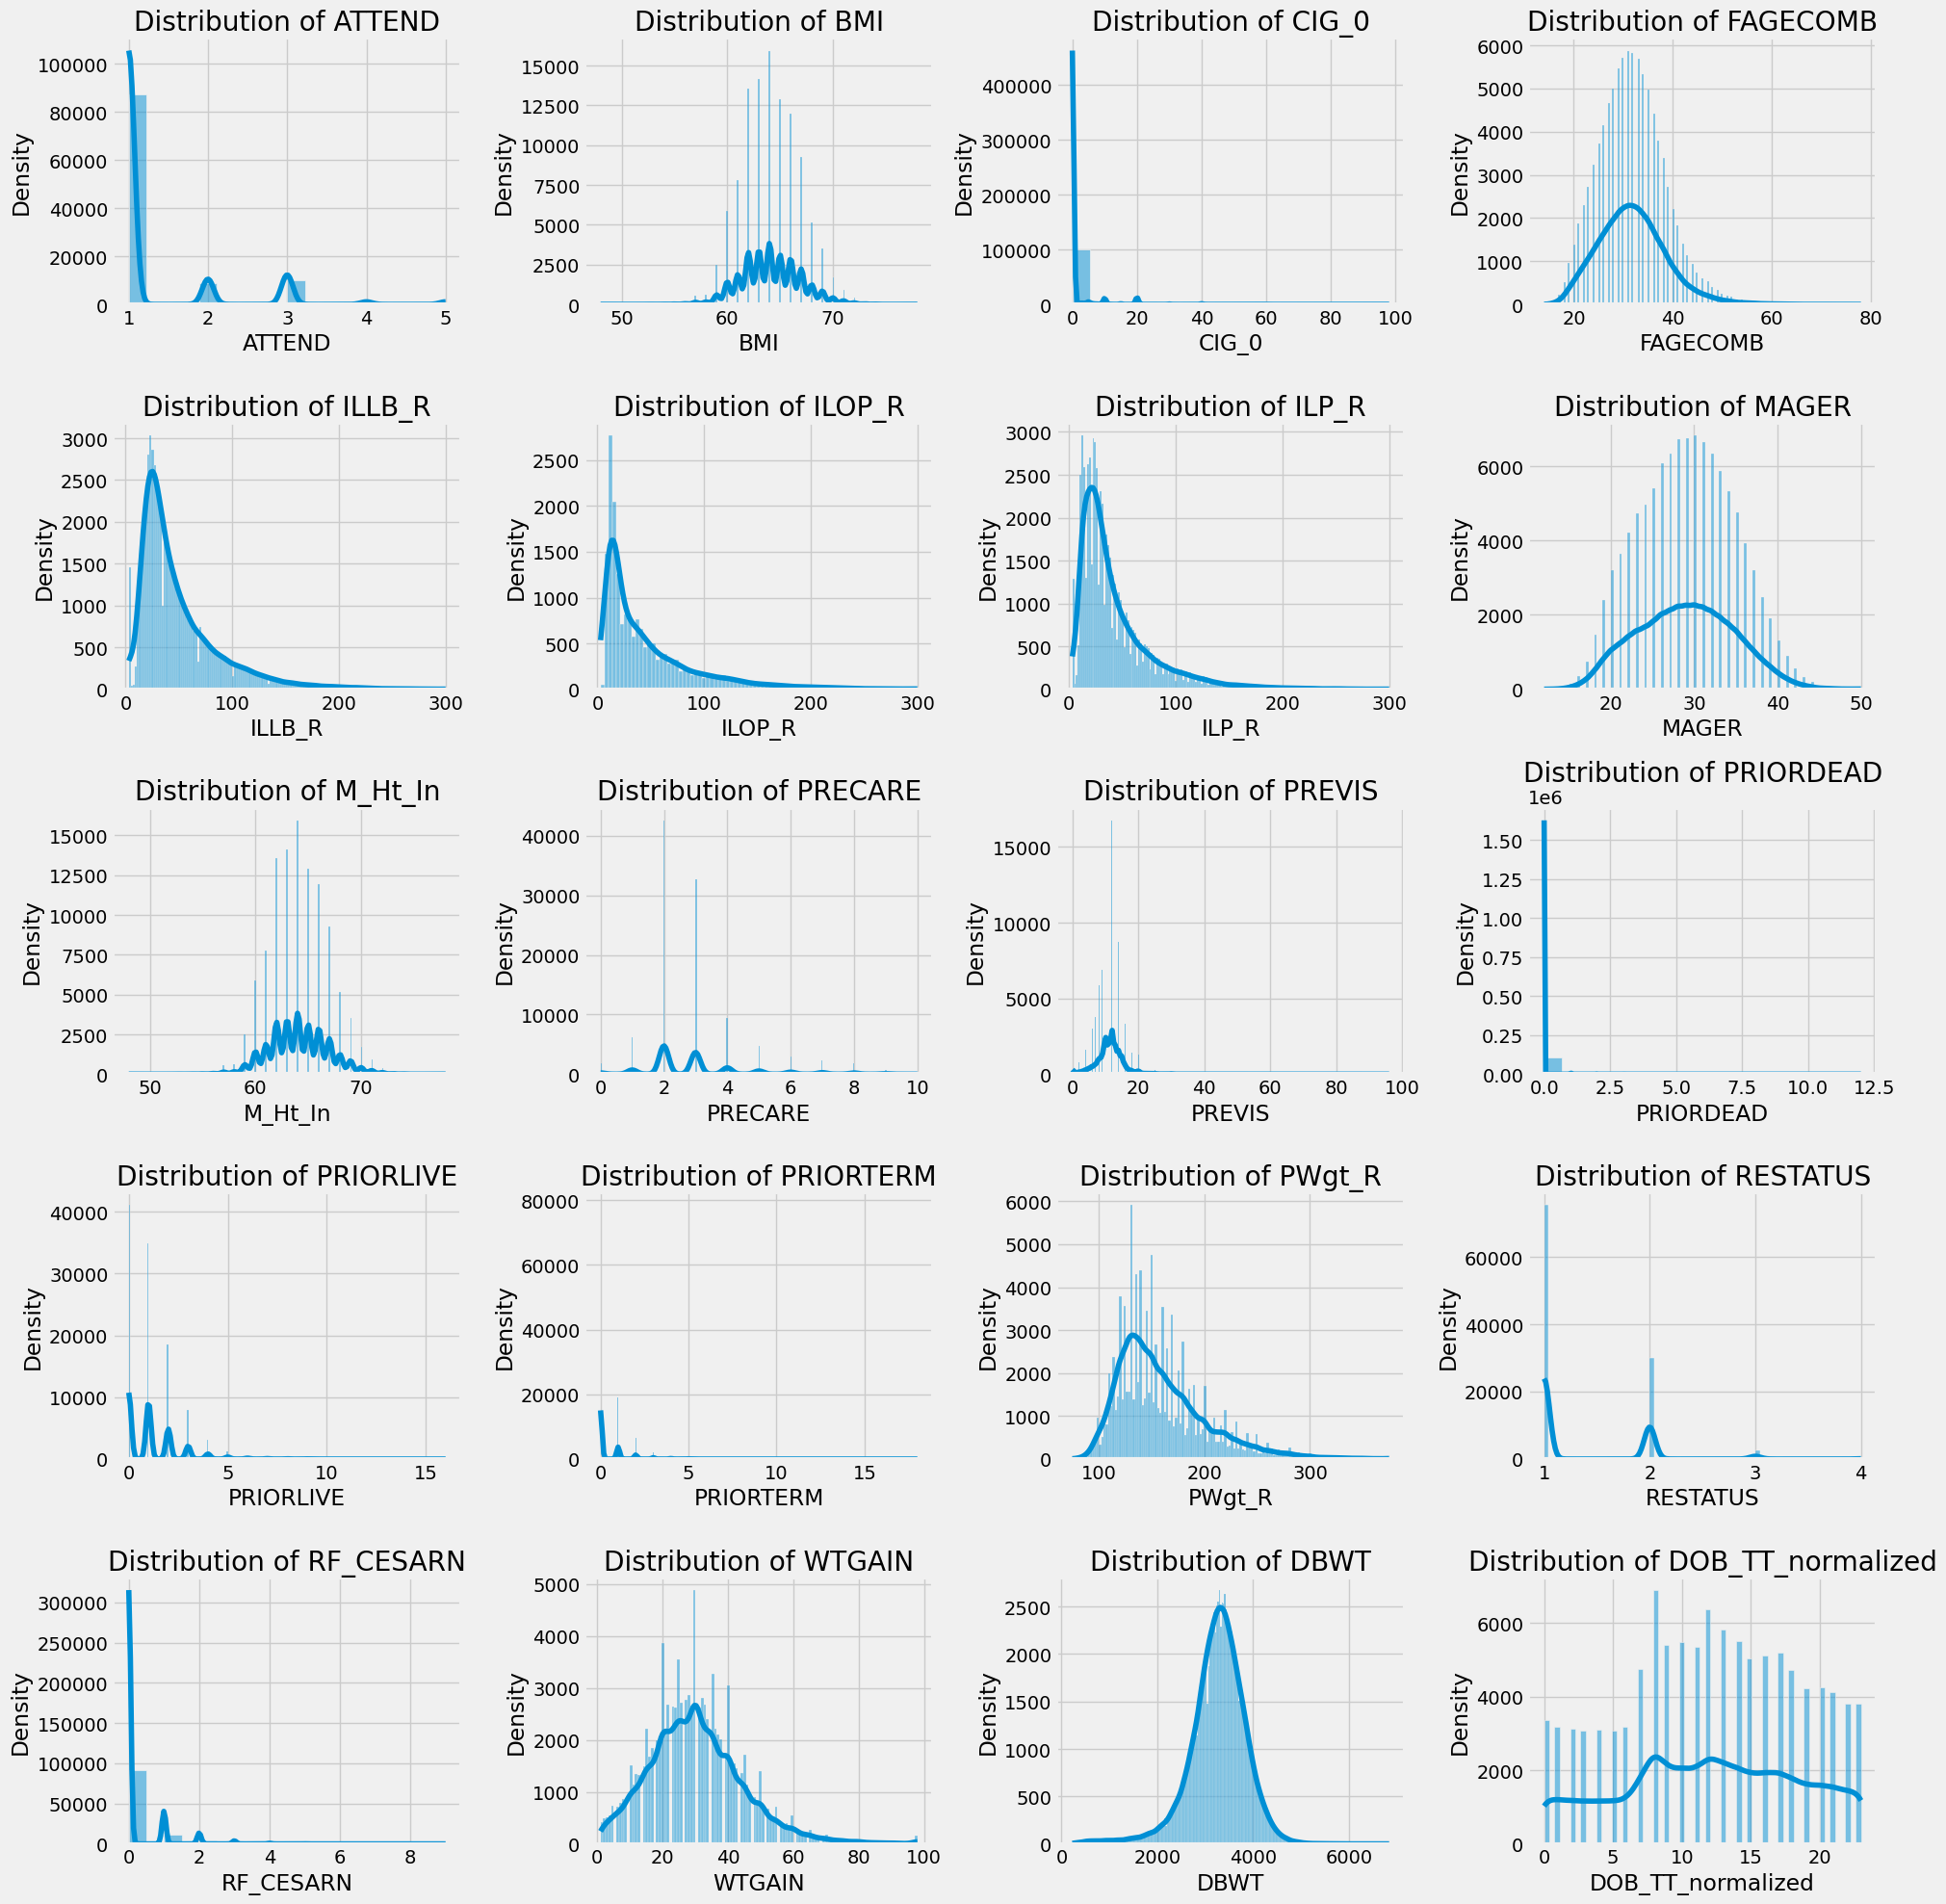

In [12]:
# plot distribution of 
numeric_cols = train.drop(columns='id').select_dtypes(include='number').columns

n_cols = 4  
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(numeric_cols):

    row = i // n_cols
    col_pos = i % n_cols

    sns.histplot(train[col], ax=axes[row, col_pos], kde=True)
    axes[row, col_pos].set_title(f'Distribution of {col}')
    axes[row, col_pos].set_xlabel(col)
    axes[row, col_pos].set_ylabel('Density')

plt.tight_layout()
plt.show()

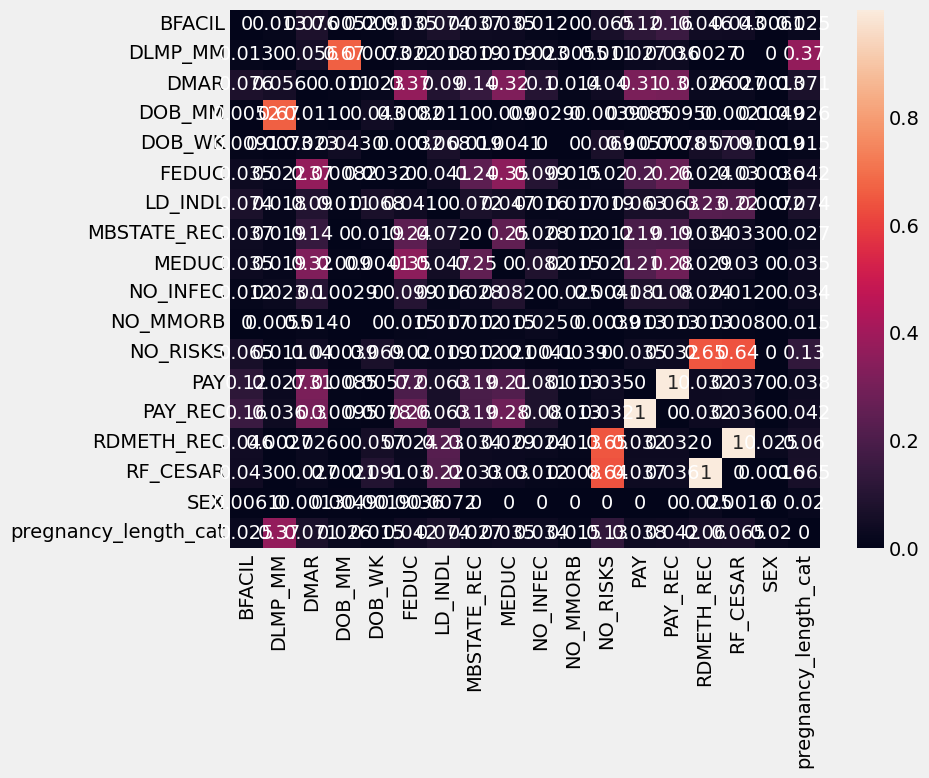

In [13]:
import itertools
from scipy.stats import chi2_contingency
# calculate cramers v
def cramers_v(x, y):
  
    crosstab = pd.crosstab(x, y)
    chi2 = chi2_contingency(crosstab)[0]
    n = crosstab.sum().sum()
    phi2 = chi2 / n
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# plot cramers v
def cramers_v_heatmap(df):
    corrM = np.zeros((len(df.columns), len(df.columns)))
    for col1, col2 in itertools.combinations(df.columns, 2):
        idx1, idx2 = df.columns.get_loc(col1), df.columns.get_loc(col2)
        corrM[idx1, idx2] = cramers_v(df[col1], df[col2])
        corrM[idx2, idx1] = corrM[idx1, idx2]
    plt.figure(figsize=(10,8))
    sns.heatmap(corrM, xticklabels=df.columns, yticklabels=df.columns, annot=True)
    plt.tight_layout()
    plt.show()
    
cramers_v_heatmap(train.drop(columns='id').select_dtypes(exclude='number'))

In [14]:
def create_train_test_split(X: pd.DataFrame, y: pd.Series, test_size: float = 0.1, random_state: int = 42):
    """
    Splits the dataset into training and testing sets.

    Parameters:
    X (pd.DataFrame): The input features.
    y (pd.Series): The target variable.
    test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.1.
    random_state (int, optional): Controls the shuffling applied to the data before applying the split. Default is 42.

    Returns:
    X_train, X_test, y_train, y_test: Split data
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

def preprocess_data(X_train: pd.DataFrame, X_test: pd.DataFrame) -> tuple:
    """
    Preprocess the data.
    Args:
        X_train: pd.DataFrame: the training data.  
        X_test: pd.DataFrame: the test data.
        
    Returns:
        X_train_prep: pd.DataFrame: the preprocessed training data.
        X_test_prep: pd.DataFrame: the preprocessed test data.
        preprocessor: The preprocessing pipeline.
    """
    # Identifying numerical and categorical features
    num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = X_train.select_dtypes(include=['category', 'object']).columns.tolist()
    # Pipeline for numerical features
    numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5, weights='uniform')),
        ('scaler', StandardScaler())
    ])
    
    # Preprocessor with only numerical transformations as CatBoost handles categorical features natively
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_features)
        ],
        remainder='passthrough'  # This will allow categorical features to be passed as is
    )

    # Fitting and transforming the training data
    X_train_prep = preprocessor.fit_transform(X_train)
    X_train_prep = pd.DataFrame(X_train_prep, columns=num_features + cat_features)

    # Transforming the testing data
    X_test_prep = preprocessor.transform(X_test)
    X_test_prep = pd.DataFrame(X_test_prep, columns=num_features + cat_features)
    
    for col in num_features:
        X_train_prep = X_train_prep.astype({col:float}) 
        X_test_prep = X_test_prep.astype({col:float}) 
        
    for col in cat_features: 
        X_train_prep = X_train_prep.astype({col:'category'})
        X_test_prep = X_test_prep.astype({col:'category'})
        
    return X_train_prep, X_test_prep, preprocessor

In [15]:
X_train, X_test, y_train, y_test = create_train_test_split(train.drop(columns=['id','DBWT']), train.DBWT,0.2)

In [16]:
X_train_prep, X_test_prep, preprocessor = preprocess_data(X_train, X_test)

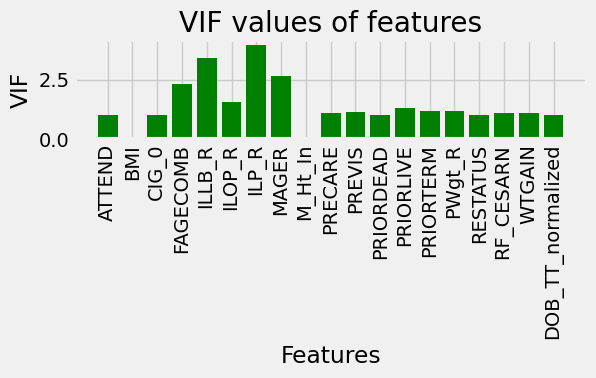

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Plot the VIF values
def vif_plot(X):
    vifs = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    feature_orig = list(X.columns)
    plt.figure(figsize=(6, 4))
    plt.bar(feature_orig, vifs, color='green')
    plt.title('VIF values of features')
    plt.xlabel('Features')
    plt.ylabel('VIF')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()  
    
vif_plot(X_train_prep.select_dtypes(include='number'))

In [18]:
#import numpy as np
#import optuna
#from catboost import CatBoostRegressor
#from sklearn.model_selection import train_test_split, KFold
#from sklearn.metrics import mean_squared_error

#def optuna_model(X: pd.DataFrame, y: pd.Series, n_trial: int, splits: int):
    # Splitting the dataset for training and testing
  #  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    # KFold for cross-validation
   # kf = KFold(n_splits=splits, shuffle=True, random_state=42)
    
    # Identifying categorical features
    #cat_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
    #print("Categorical features:", cat_features)

    # Objective function for CatBoost
    #def cat_objective(trial):
     #   params = {
      #      'eval_metric':'Quantile',
       #     'loss_function':'Quantile:alpha=0.1',
        #    'random_seed': 42,
         #   'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
          #  'depth': trial.suggest_int('depth', 4, 10),
           # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
           # 'border_count': trial.suggest_int('border_count', 32, 255),
           # 'random_strength': trial.suggest_float('random_strength', 0, 10),
           # 'iterations': trial.suggest_int('iterations', 100, 1000),
           # 'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bernoulli']),
           # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
            #'od_type': 'IncToDec',
           # 'od_pval': trial.suggest_float('od_pval', 0.001, 0.1),
            #'task_type': 'GPU',
            #'devices': '0:1',
       # }
        
       # regressor = CatBoostRegressor(**params)
       # quantile_losses = []
        
       # for train_index, val_index in kf.split(X_train):
       #     X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
       #     y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
            
       #     regressor.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], cat_features=cat_features, verbose=0)
       #     preds = regressor.predict(X_val_fold)
            # Calculate the quantile loss for each fold
      #      quantile_loss = np.mean(np.maximum(0.1 * (y_val_fold - preds), (1 - 0.1) * (preds - y_val_fold)))
       #     quantile_losses.append(quantile_loss)
        
       # print(f'Trial done: Quantile loss values on folds: {quantile_losses}')
       # return np.mean(quantile_losses)

    # Optuna study
   # cat_study = optuna.create_study(direction='minimize')
   # cat_study.optimize(cat_objective, n_trials=n_trial)

    # Best parameters
   # cat_params = cat_study.best_trial.params
   # cat_params['random_seed'] = 42
    
   #return cat_params, feature_importance

# Usage
# cat_params= optuna_model(X_train_prep, y_train, 20, 5)

In [19]:
# best run from last time
cat_params={'learning_rate': 0.02897385212550195,
            'depth': 5,
            'l2_leaf_reg': 0.08583424391547381,
            'border_count': 197,
            'random_strength': 0.023982232779840018, 
            'iterations': 769,
            'bootstrap_type': 'Bernoulli',
            'grow_policy': 'Lossguide'}

In [20]:
features = sorted(set(X_train.columns) - set(['id']))
cat_features = X_train.select_dtypes(include=['category', 'object']).columns.tolist()
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [21]:
RANDOM_STATE = 2112
N_REPEATS = 5
N_FOLDS = 5


def fold_train_data(random_state, train_data, n_folds):
    result = train_data.copy()
    k_fold = KFold(n_splits=n_folds, random_state=random_state, shuffle=True)
    folds = k_fold.split(train_data, train_data[TARGET_NAME])
                        
    result['fold'] = 0
    for fold, (_, val_index) in enumerate(folds):
        result.loc[val_index, 'fold'] = fold
    return result

def fold_metric(y_true, y_pred):
    MWIS, coverage = MWIS_metric.score(y_true, y_pred[:, 0],  y_pred[:, 1], 0.1)
    print(f'MWIS: {MWIS:4.2f}, Coverage %: {coverage * 100:3.2f}')
    return MWIS

In [22]:
train_data = preprocessor.transform(train.drop(columns=['id','DBWT']))
train_data = pd.concat([pd.DataFrame(train_data, columns=num_features + cat_features),train[['id','DBWT']]],axis=1)
test_data = preprocessor.transform(test.drop(columns='id'))
test_data = pd.concat([test[['id']],pd.DataFrame(test_data, columns=num_features + cat_features)],axis=1)

In [23]:
# we're aiming for 90% prediction intervals
ALPHA = 0.1

def fit_cat(train_data, test_data, features, n_repeats=1):
    # fit L
    # evaluate OOF, shap, and feature importance
    
    test_preds = np.zeros((len(test_data), 2))
    oof_preds  = np.zeros((len(train_data), 2))
    fis = []
    shap_values = None
    shap_vl = None
    
    n_folds = N_FOLDS
    repeat_metrics = []
    for i in range(n_repeats):
        df = fold_train_data(RANDOM_STATE + i, train_data, n_folds)
        oof_pred = np.zeros((len(df), 2))
        for fold in range(n_folds):
            tr = df.query("fold != @fold")
            vl = df.query("fold == @fold")

            # split into validation and calibration 
            vl_1, vl_2 = train_test_split(vl, 
                test_size=0.5, random_state=RANDOM_STATE + i, shuffle=True) 
            
            params = cat_params.copy()
            
            # fit model to training data
            # for each quantile of interest
            # MAPIE also needs the median:
            alphas = [ALPHA / 2, 1 - (ALPHA / 2), 0.5]  # lower, upper, median
            models = []
            for alpha in alphas:
                m = CatBoostRegressor(loss_function=f'Quantile:alpha={alpha}',cat_features=cat_features, silent=True,
                    **params)
                m.fit(tr[features], tr[TARGET_NAME])
                models.append(m)
            
            # evaluate shap values
            # for the first fold only, for the median model
            if shap_values is None:
                shap_vl = vl.copy()
                shap_values = shap.TreeExplainer(models[2]).shap_values(shap_vl[features])
            
            # evaluate permutation importance:
            try:
                imp = permutation_importance(
                    models[2], vl[features], vl[TARGET_NAME])
                fi = pd.DataFrame({
                    'Importance': imp.importances_mean,
                    'Feature': features})
                fis.append(fi)
            except:
                pass

            # use v1 for calibration, predict v2
            cqr = MapieQuantileRegressor(models, alpha=ALPHA, cv="prefit")
            cqr.fit(vl_1[features], vl_1[TARGET_NAME])
            _, y_qr2 = cqr.predict(vl_2[features], alpha=ALPHA)
            _, y_test2 = cqr.predict(test_data[features], alpha=ALPHA)

            # use v2 for calibration, predict v1
            cqr = MapieQuantileRegressor(models, alpha=ALPHA, cv="prefit")
            cqr.fit(vl_2[features], vl_2[TARGET_NAME])
            _, y_qr1 = cqr.predict(vl_1[features], alpha=ALPHA)
            _, y_test1 = cqr.predict(test_data[features], alpha=ALPHA)
            
            oof_pred[vl_1.index, 0] = y_qr1[:, 0].flatten()
            oof_pred[vl_1.index, 1] = y_qr1[:, 1].flatten()
            oof_pred[vl_2.index, 0] = y_qr2[:, 0].flatten()
            oof_pred[vl_2.index, 1] = y_qr2[:, 1].flatten()
            
            # mean of predictions over the reps
            # Maybe take shortest?
            oof_preds[vl_1.index, 0] += y_qr1[:, 0].flatten() / (n_repeats)
            oof_preds[vl_1.index, 1] += y_qr1[:, 1].flatten() / (n_repeats)
            oof_preds[vl_2.index, 0] += y_qr2[:, 0].flatten() / (n_repeats)
            oof_preds[vl_2.index, 1] += y_qr2[:, 1].flatten() / (n_repeats)
            
            test_preds[:, 0] += y_test1[:, 0].flatten() / (n_repeats * N_FOLDS * 2)
            test_preds[:, 1] += y_test1[:, 1].flatten() / (n_repeats * N_FOLDS * 2)
            test_preds[:, 0] += y_test2[:, 0].flatten() / (n_repeats * N_FOLDS * 2)
            test_preds[:, 1] += y_test2[:, 1].flatten() / (n_repeats * N_FOLDS * 2)
   
        metric = fold_metric(df[TARGET_NAME], oof_pred)
        repeat_metrics.append(metric)
        
    print('\nOverall Metric:')
    fold_metric(df[TARGET_NAME], oof_preds)
    
    return (
        oof_preds, test_preds, 
        repeat_metrics, fis, 
        shap_values, shap_vl)

In [24]:
(oof_preds, 
 test_preds, 
 oof_fold_metrics, 
 fis,
 shap_values, shap_vl) = fit_cat(train_data, test_data, features, N_REPEATS)

MWIS: 1955.11, Coverage %: 90.02
MWIS: 1956.12, Coverage %: 90.03
MWIS: 1955.43, Coverage %: 90.02
MWIS: 1955.61, Coverage %: 90.03
MWIS: 1955.68, Coverage %: 90.00

Overall Metric:
MWIS: 1952.46, Coverage %: 90.06


In [25]:
## OOF predictions
(train_data.assign(**{
        'pi_lower': oof_preds[:, 0],
        'pi_upper': oof_preds[:, 1]})
    .filter(['id', TARGET_NAME, 'pi_lower', 'pi_upper'])
    .to_csv('oof.csv', index=False))

pd.read_csv('oof.csv').head(10)

,id,DBWT,pi_lower,pi_upper
0,0,2800,2522.457229,3745.647562
1,1,1900,2049.453727,3428.951368
2,2,2960,2435.260739,3850.139617
3,3,3657,2493.574957,3924.140702
4,4,3742,2608.309448,3947.165300
5,5,3317,2733.435387,4045.126711
6,6,3550,1796.251396,4290.472897
7,7,515,903.410802,3459.569545
8,8,2438,2035.644782,3707.671671
9,9,4015,3003.698153,4357.192172


In [26]:
## Submission
(test_data
    .assign(**{
        'pi_lower': test_preds[:, 0],
        'pi_upper': test_preds[:, 1]})
    .filter(['id', 'pi_lower', 'pi_upper'])
    .to_csv('submission.csv', index=False))

pd.read_csv('submission.csv').head(10)

,id,pi_lower,pi_upper
0,108082,2585.265520,4249.735261
1,108083,2517.475072,3695.422876
2,108084,2615.791051,3988.167535
3,108085,2545.819022,3884.614263
4,108086,2431.275220,3807.555961
5,108087,1714.963310,3874.742008
6,108088,2942.184546,4505.046909
7,108089,2877.408534,4436.777920
8,108090,2636.523250,3978.920777
9,108091,2852.667330,4215.464689
